# Upscaling unstructured grids

This notebook presents how to upscale a fine structured grid to a coarse unstructured grid using uppy. Grid are generated using flopy and gridgen.

Note that grid cells need to be rectangles.

Multiple type of grids are presented:
- 2D DISV grid (see modflow 6 documentation)
- 3D DISV grid
- 3D DISU grid

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import flopy
from flopy.utils.gridgen import Gridgen
from flopy.export.vtk import Vtk
import pyvista as pv

# import uppy
sys.path.append("../../")
import ArchPy
import ArchPy.uppy
from ArchPy.uppy import upscale_k, upscale_k_2D, rotate_point

In [2]:
gridgen_path = "../../../../exe/gridgen.exe"

## 2D DISV

Let's create a 2D unstructured grid using gridgen and flopy

In [3]:
# grid dimensions
nlay = 1
nrow = 8
ncol = 8
delr = 100.
delc = 100.
top = 0.
botm = -100.


sim = flopy.mf6.MFSimulation(
    sim_name="asdf", sim_ws="ws", exe_name="mf6")
tdis = flopy.mf6.ModflowTdis(sim, time_units="DAYS", perioddata=[[1.0, 1, 1.0]])
ms = flopy.mf6.ModflowGwf(sim, modelname="asdf", save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xorigin=1103.3,
    yorigin=1103.5,
)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws="gridgen_ws", exe_name=gridgen_path)  # ! modidfy path to gridgen.exe !

# polygon refinement in the center of the grid (size 250 x 250)
polygon = [
    [
        (1600, 1350),
        (1700, 1300),
        (1300, 1800),
        (1300, 1700),
        (1600, 1350),
    ]
]


g.add_refinement_features([polygon], "polygon", 3, range(nlay))  # refinement level
refshp0 = "gridgen_ws/" + "rf0"


In [4]:
ms.modelgrid

xll:1103.3; yll:1103.5; rotation:0.0; units:undefined; lenuni:0

Build refinement

In [5]:
g.build(verbose=False)
grid = flopy.discretization.VertexGrid(**g.get_gridprops_vertexgrid())

In [6]:
grid.ncpl  # number of cells

523

Possible issue encountered when converting Shape #0 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.


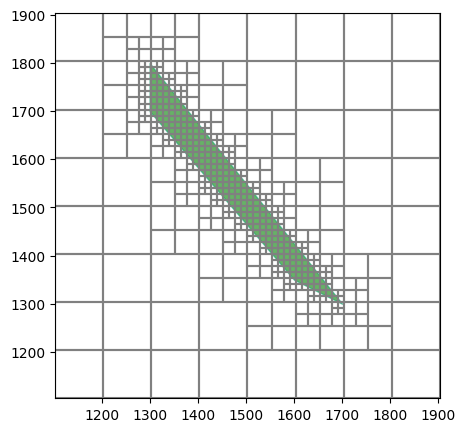

In [7]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
mm = flopy.plot.PlotMapView(model=ms)
grid.plot(ax=ax)

flopy.plot.plot_shapefile(refshp0, ax=ax, facecolor="green", alpha=0.6)

In [8]:
disv_gridprops = g.get_gridprops_disv()  # get the disv gridprops

In [9]:
# remove existing dis package and add new disv package
ms.dis.remove()
disv = flopy.mf6.ModflowGwfdisv(ms, **disv_gridprops, xorigin=0, yorigin=0)  # it is important to set xorigin and yorigin to 0, 0

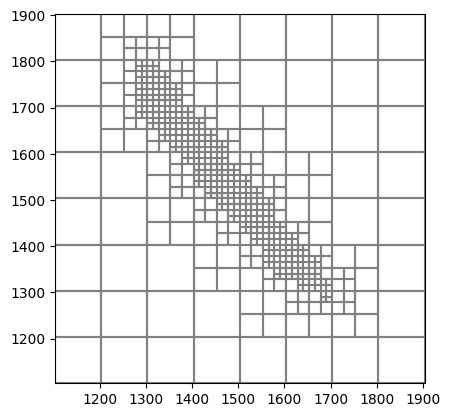

In [10]:
ms.modelgrid.plot()

Now we generate a reference K field. Note that the field that is upscaled must be larger (or equivalent), in extension, than the new coarse grid

In [11]:
# generate a random field for the grid
import geone

np.random.seed(16)

cm = geone.covModel.CovModel2D(elem=[("spherical", {"w":.5, "r":[250, 450]})
                                    ], alpha=30,
                                name="model")
nx_grid, ny_grid = 100, 100
sx_grid, sy_grid = 10, 10
ox_grid, oy_grid = 1000, 1000
field = geone.multiGaussian.multiGaussianRun(cm, (nx_grid, ny_grid), (sx_grid, sy_grid), (ox_grid, oy_grid), output_mode="array", mean=-5)

grf2D: Preliminary computation...
grf2D: Computing circulant embedding...
grf2D: embedding dimension: 128 x 256
grf2D: Computing FFT of circulant matrix...


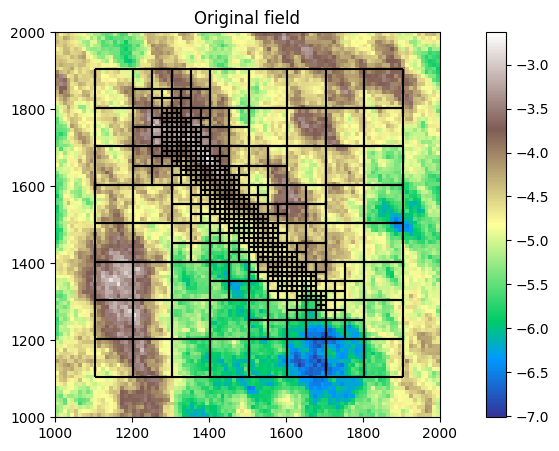

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))

grid.plot(ax=ax, color="k")

plt.imshow(field[0], cmap="terrain", vmin=field[0].min(), vmax=field[0].max(), extent=[ox_grid, ox_grid+sx_grid*nx_grid, oy_grid, oy_grid+sy_grid*ny_grid])
plt.xlim(ox_grid, ox_grid+sx_grid*nx_grid)
plt.ylim(oy_grid, oy_grid+sy_grid*ny_grid)
plt.colorbar()
plt.title("Original field")
plt.show()

### Upscaling

The available method for the upscaling are:
- arithmetic mean
- harmonic mean
- geometric mean
- Simplified renormalization

Note that upscaling function (upscale_k_2D and upscale_k) need to be compiled first by numba. Hence the first call to the function will be slow.

In [13]:
field = 10**field

In [14]:
new_k = upscale_k_2D(field[0], dx=sx_grid, dy=sy_grid, ox=ox_grid, oy=oy_grid, method="simplified_renormalization", grid=grid)

In [15]:
%%time
# new_k_g = upscale_k_2D(field[0], dx=sx_grid, dy=sy_grid, ox=ox_grid, oy=oy_grid, method="geometric", grid=grid)
# new_k_h = upscale_k_2D(field[0], dx=sx_grid, dy=sy_grid, ox=ox_grid, oy=oy_grid, method="harmonic", grid=grid)
# new_k_m = upscale_k_2D(field[0], dx=sx_grid, dy=sy_grid, ox=ox_grid, oy=oy_grid, method="arithmetic", grid=grid)
new_k = upscale_k_2D(field[0], dx=sx_grid, dy=sy_grid, ox=ox_grid, oy=oy_grid, method="simplified_renormalization", grid=grid)

CPU times: total: 484 ms
Wall time: 479 ms


In [16]:
new_k = np.log10(new_k)

Let's compare to a standard upscaling using a structured grid

In [17]:
%%time
Kxx, Kyy = upscale_k_2D(field[0], dx=5, dy=5, factor_x=5, factor_y=5)

CPU times: total: 172 ms


Wall time: 180 ms


In [18]:
Kxx = np.log10(Kxx)
Kyy = np.log10(Kyy)

In [19]:
field = np.log10(field)

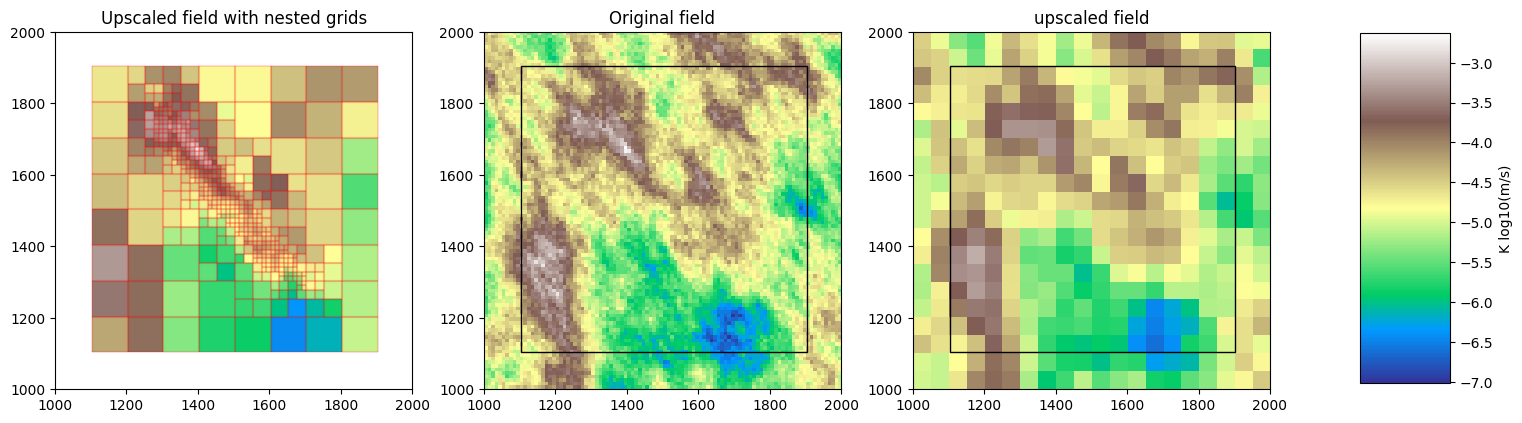

In [20]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

mm = flopy.plot.PlotMapView(model=ms, ax=ax[0])
mm.plot_grid(color="red", alpha=.15)
mm.plot_array(new_k[1], alpha=1, cmap="terrain", vmin=field[0].min(), vmax=field[0].max())
ax[0].set_xlim(ox_grid, ox_grid + 1000)
ax[0].set_ylim(oy_grid, oy_grid + 1000)
ax[0].set_title("Upscaled field with nested grids")
ax[0].set_aspect("equal")

ax[1].imshow(field[0], cmap="terrain", vmin=field[0].min(), vmax=field[0].max(), extent=(ox_grid, ox_grid + 1000, oy_grid, oy_grid + 1000))
#draw rectangle of the size of field
extent = ms.modelgrid.extent
x1, x2, y1, y2 = extent
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor="black", facecolor="none")
ax[1].add_patch(rect)
# plt.colorbar()
# grid_ref.plot(alpha=.2, ax=ax[1])
ax[1].set_title("Original field")
ax[1].set_aspect("equal")

g = ax[2].imshow(Kyy, cmap="terrain", vmin=field[0].min(), vmax=field[0].max(), extent=(ox_grid, ox_grid + 1000, oy_grid, oy_grid + 1000))
# plt.colorbar()
rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor="black", facecolor="none")
ax[2].add_patch(rect)
ax[2].set_title("upscaled field")
ax[2].set_aspect("equal")

# add colorbar
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cl = fig.colorbar(g, cax=cbar_ax)
cl.set_label("K log10(m/s)")

plt.show()

## 3D DISV

Same as before but here using a 3D grid

In [21]:
# 3D example
# grid dimensions
nlay = 4
nrow = 8
ncol = 8
delr = 100.
delc = 100.
top = 0.
ox = 1103.3
oy = 1103.5

botm = np.linspace(-10, -100, nlay)

sim = flopy.mf6.MFSimulation(
    sim_name="asdf", sim_ws="ws", exe_name="mf6")
tdis = flopy.mf6.ModflowTdis(sim, time_units="DAYS", perioddata=[[1.0, 1, 1.0]])
ms = flopy.mf6.ModflowGwf(sim, modelname="asdf", save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xorigin=ox,  # gridgen will be applied on a grid with origin at 0, 0
    yorigin=oy,
    angrot=0,
)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws="gridgen_ws", exe_name=gridgen_path)  

polygon = [
    [
        (1400, 1800),
        (1400, 1700),
        (1000, 1700),
        (1000, 1800),
        (1400, 1800),
    ]
]
polygon = np.array(polygon)

g.add_refinement_features([polygon], "polygon", 3, range(nlay))
refshp0 = "gridgen_ws/" + "rf0"


In [22]:
g.build(verbose=False)

In [23]:
ms.dis.remove()
disv_gridprops = g.get_gridprops_disv()
disv = flopy.mf6.ModflowGwfdisv(ms, **disv_gridprops, xorigin=0, yorigin=0)  # create grid this time with the origin at ox, oy

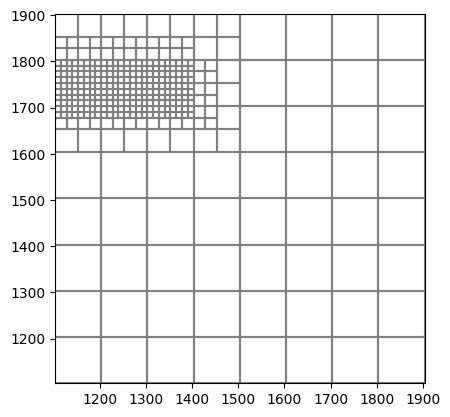

In [24]:
grid = ms.modelgrid
grid.plot()

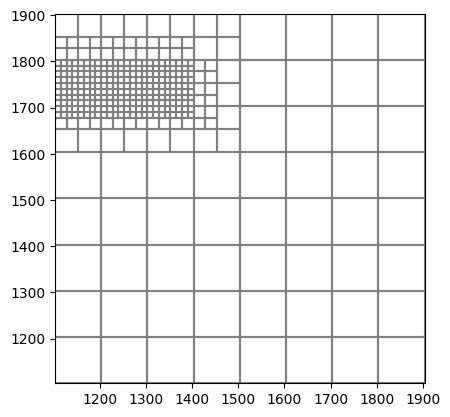

In [25]:
ms.modelgrid.plot()

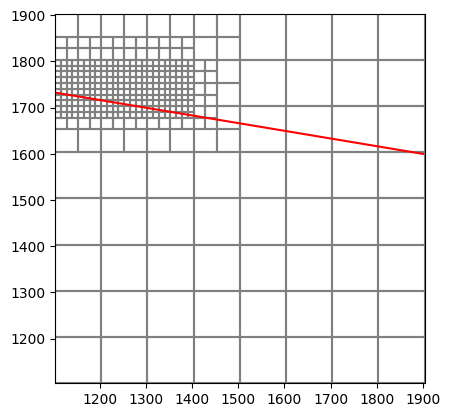

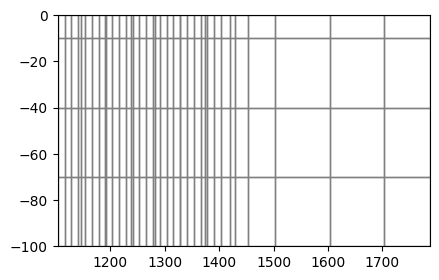

In [26]:
# plot a cross section
from flopy.plot import PlotCrossSection

linex, liney = [700, 1900], [1800, 1600]

mm = flopy.plot.PlotMapView(model=ms)
ms.modelgrid.plot()

plt.plot(linex, liney, "r-")
plt.show()

fig = plt.figure(figsize=(4.8, 3))
xsect = PlotCrossSection(model=ms,geographic_coords=True, line={"line": [linex, liney]})
xsect.plot_grid()



In [27]:
# generate a random field for the grid
import geone

np.random.seed(15)

cm = geone.covModel.CovModel3D(elem=[("spherical", {"w":1, "r":[250, 450, 50]})
                                    ], alpha=30,
                                name="model")

# grid parameters
nx_grid, ny_grid, nz_grid = 100, 100, 100
sx_grid, sy_grid, sz_grid = 10, 10, 1
ox_grid, oy_grid, oz_grid = 1000, 1000, -100
field_img = geone.multiGaussian.multiGaussianRun(cm, (nx_grid, ny_grid, nz_grid), (sx_grid, sy_grid, sz_grid), output_mode="img", mean=-5, algo="fft")

grf3D: Preliminary computation...
grf3D: Computing circulant embedding...
grf3D: embedding dimension: 128 x 256 x 128


grf3D: Computing FFT of circulant matrix...


In [28]:
pv.set_jupyter_backend('client')

In [29]:
# create a modflow grid of the resolution of the random field to check the extent of the two grids

field = field_img.val[0]
field = np.flip(np.flipud(field), axis=1)  # flip the field to have the same orientation as the grid
nrow = field.shape[1]
ncol = field.shape[2]
nlay = field.shape[0]
botm = np.linspace(-1, -100, nlay)
# transform botm to have the same shape as the field
botm = np.repeat(botm.reshape(-1, 1, 1), nrow, axis=1)
botm = np.repeat(botm, ncol, axis=2)
top = np.zeros((nrow, ncol))
grid_ref = flopy.discretization.StructuredGrid(nrow=field.shape[1], ncol=field.shape[2], nlay=field.shape[0],
                                               delr=np.ones((field.shape[2]))*sx_grid, delc=np.ones((field.shape[1]))*sy_grid,
                                               botm=botm, top=top,
                                               xoff=1000, yoff=1000, angrot=0)

Check superposition of the two grids

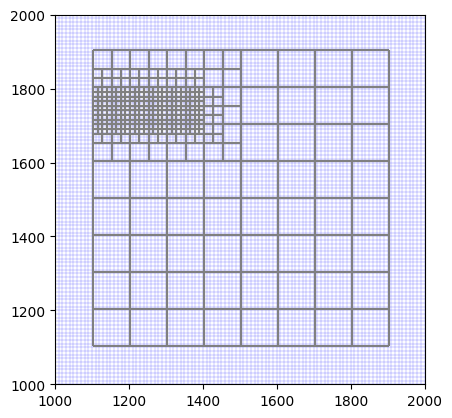

In [30]:
grid = ms.modelgrid
grid_ref.plot(alpha=.1, color="blue")
grid.plot()

In [31]:
field = 10**field

In [32]:
Kxx, Kyy, Kzz = upscale_k(field, dx=sx_grid, dy=sy_grid, dz=sz_grid, ox=ox_grid, oy=oy_grid, oz=oz_grid, method="simplified_renormalization", grid=grid)

In [33]:
Kxx = np.log10(Kxx)
Kyy = np.log10(Kyy)
Kzz = np.log10(Kzz)

(array([ 10.,  34., 434., 559., 181.,  99.,  59.,  27.,  21.,  20.]),
 array([-0.63239505, -0.37297911, -0.11356318,  0.14585276,  0.40526869,
         0.66468463,  0.92410056,  1.18351649,  1.44293243,  1.70234836,
         1.9617643 ]),
 <BarContainer object of 10 artists>)

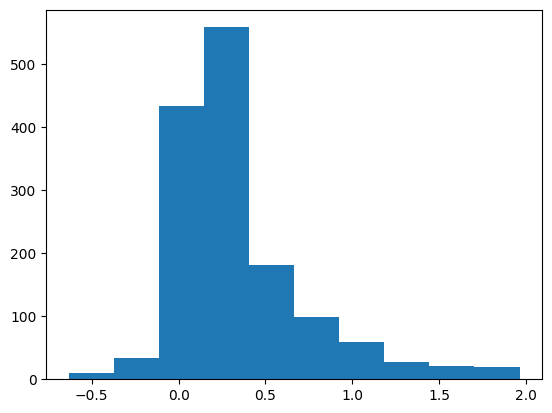

In [34]:
plt.hist((Kxx - Kzz).flatten())

In [35]:
field_kxx, fieldkyy, field_kzz = upscale_k(field, method="simplified_renormalization", dx=10, dy=10, dz=1, factor_x=10, factor_y=10, factor_z=10)

In [36]:
field_kxx = np.log10(field_kxx)
field_kyy = np.log10(fieldkyy)
field_kzz = np.log10(field_kzz)

In [37]:
# get number of cells in field_kxx
nlay = field_kxx.shape[0]
nrow = field_kxx.shape[1]
ncol = field_kxx.shape[2]
ncells = nlay*nrow*ncol
ncells

1000

In [38]:
vert_exag = 1
vtk = Vtk(model=ms, binary=False, vertical_exageration=vert_exag, smooth=True)
vtk.add_model(ms)
vtk.add_array(Kxx, name="K")
vtk.add_array(Kyy, name="Kyy")
vtk.add_array(Kzz, name="Kzz")
gwf_mesh = vtk.to_pyvista()

In [39]:
ms.dis.yorigin = 0
ms.dis.xorigin = 0

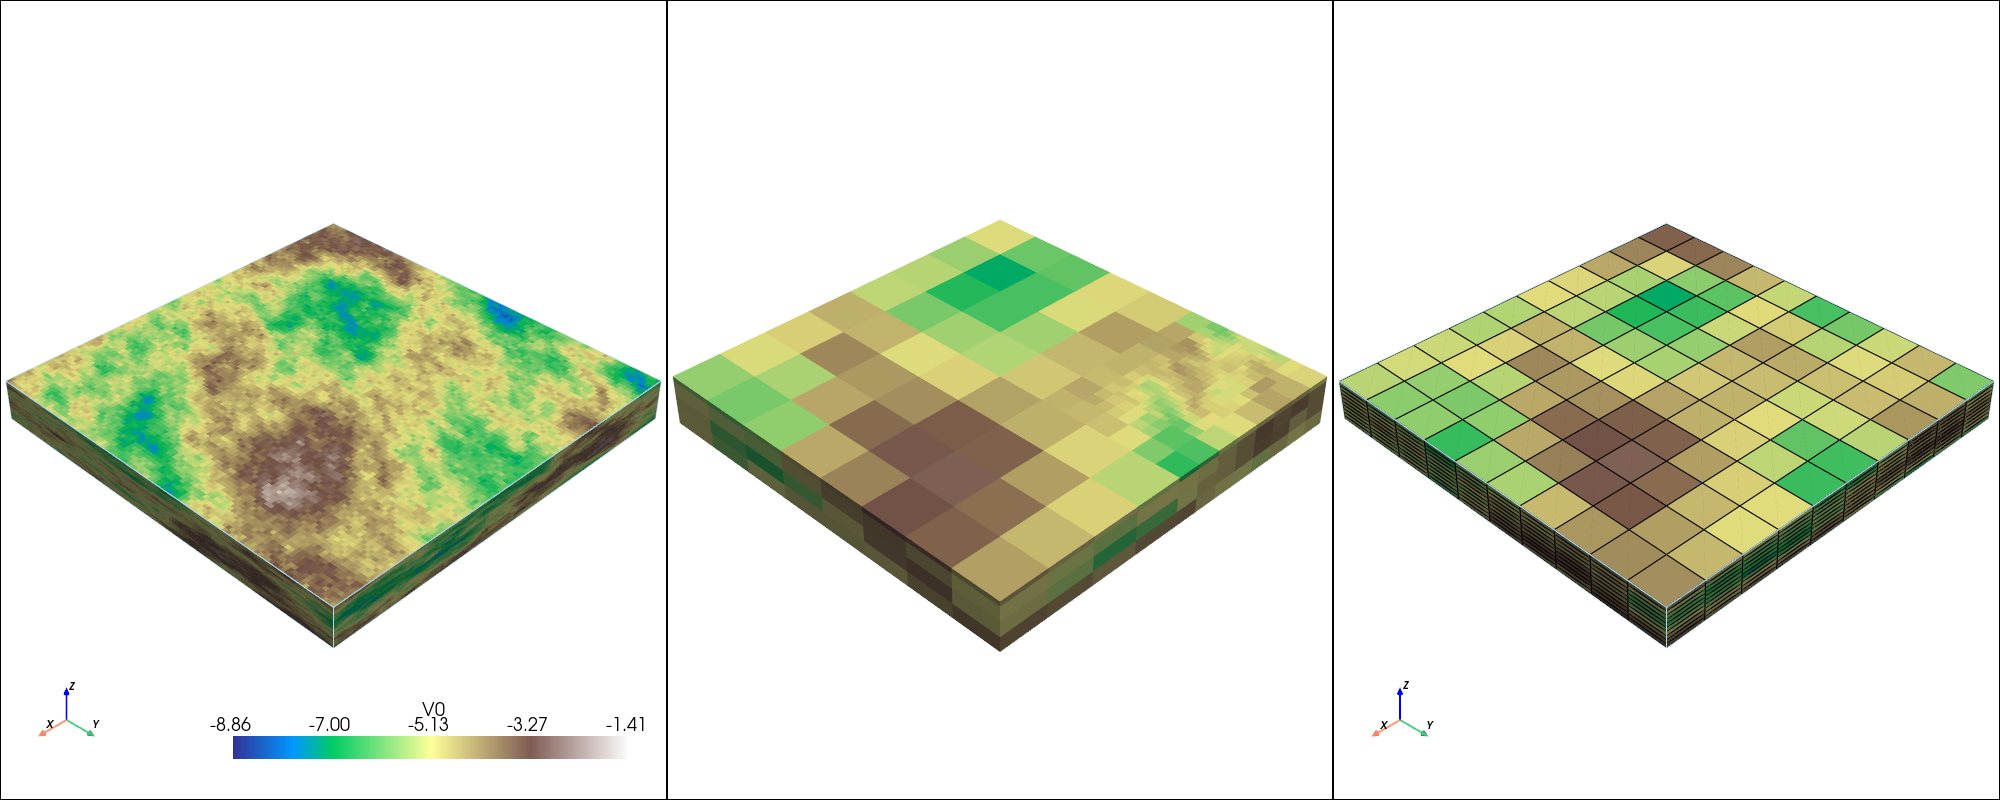

In [40]:
import pyvista as pv
pv.set_plot_theme("document")
pv.set_jupyter_backend('static')

pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
pl.subplot(0, 0)
geone.imgplot3d.drawImage3D_surface(field_img, plotter=pl, cmap="terrain", opacity=1)

pl.subplot(0, 1)
pl.add_mesh(gwf_mesh, opacity=1, scalars="K", cmap="terrain", clim=[field_img.val.min(), field_img.val.max()], show_edges=False, show_scalar_bar=False)

pl.subplot(0, 2)
arr = field_kxx
arr = np.flipud(np.flip(arr, axis=1))   
img = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=sx_grid*10, sy=sy_grid*10, sz=sz_grid*10, ox=0, oy=0, oz=-100, nv=1, val=arr.flatten())  
geone.imgplot3d.drawImage3D_surface(img, plotter=pl, cmap="terrain", opacity=1, cmin=field_img.val.min(), cmax=field_img.val.max(), show_edges=True)

pl.show()

The unstructured upscaled model looks different than reference and structured upscaled model because of the extent that is different. unstructured grid is slightly smaller than the reference grid.

## 3D DISU

Uppy can also work with DISU grids. As long as the cells of the grid are rectangles, upscaling is possible.

In [41]:
# 3D example
# grid dimensions
nlay = 4
nrow = 8
ncol = 8
delr = 100.
delc = 100.
top = 0.
botm = np.linspace(-10, -100, nlay)

sim = flopy.mf6.MFSimulation(
    sim_name="asdf", sim_ws="ws", exe_name="mf6")
tdis = flopy.mf6.ModflowTdis(sim, time_units="DAYS", perioddata=[[1.0, 1, 1.0]])
ms = flopy.mf6.ModflowGwf(sim, modelname="asdf", save_flows=True)
dis = flopy.mf6.ModflowGwfdis(
    ms,
    nlay=nlay,
    nrow=nrow,
    ncol=ncol,
    delr=delr,
    delc=delc,
    top=top,
    botm=botm,
    xorigin=1103.3,
    yorigin=1103.5,
)

# create Gridgen object
g = Gridgen(ms.modelgrid, model_ws="gridgen_ws", exe_name=gridgen_path)

polygon = [
    [
        (1600, 1350),
        (1700, 1300),
        (1300, 1800),
        (1300, 1700),
        (1600, 1350),
    ]
]


g.add_refinement_features([polygon], "polygon", 3, range(1))
refshp0 = "gridgen_ws/" + "rf0"


In [42]:
g.build(verbose=False)

In [43]:
ms.dis.remove()
# disv_gridprops = g.get_gridprops_disv()
grid_prop_disu = g.get_gridprops_disu6()
# disv = flopy.mf6.ModflowGwfdisv(ms, **disv_gridprops, xorigin=0, yorigin=0)
disu = flopy.mf6.ModflowGwfdisu(ms, **grid_prop_disu, xorigin=0, yorigin=0)

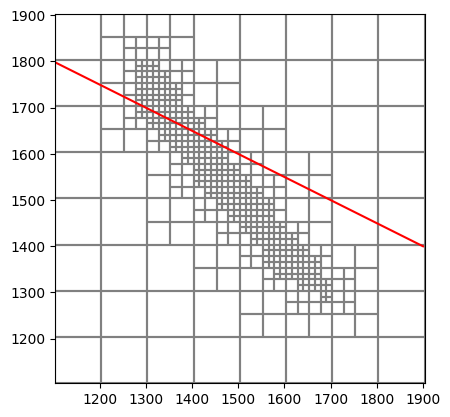

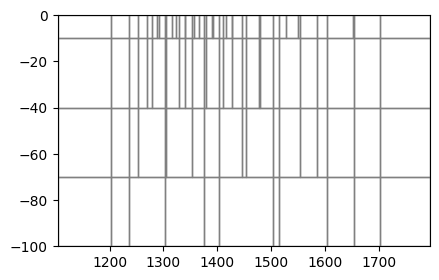

In [44]:
# plot a cross section
from flopy.plot import PlotCrossSection

linex, liney = [1100, 1900], [1800, 1400]

mm = flopy.plot.PlotMapView(model=ms)
mm.plot_grid()
plt.plot(linex, liney, "r-")
plt.show()

fig = plt.figure(figsize=(4.8, 3))
xsect = PlotCrossSection(model=ms,geographic_coords=True, line={"line": [linex, liney]})
xsect.plot_grid()
plt.show()  

In [45]:
grid = ms.modelgrid

In [46]:
Kxx, Kyy, Kzz = upscale_k(field, dx=sx_grid, dy=sy_grid, dz=sz_grid, ox=ox_grid, oy=oy_grid, oz=oz_grid, method="simplified_renormalization", grid=grid)  # upscale the field

In [47]:
Kxx = np.log10(Kxx)
Kyy = np.log10(Kyy)
Kzz = np.log10(Kzz)

In [48]:
#extract vtk params for plotting with pyvista
vert_exag = 1
vtk = Vtk(model=ms, binary=False, vertical_exageration=vert_exag, smooth=False)
vtk.add_model(ms)
vtk.add_array(Kxx, name="K")
vtk.add_array(Kyy, name="Kyy")
vtk.add_array(Kzz, name="Kzz")
gwf_mesh = vtk.to_pyvista()

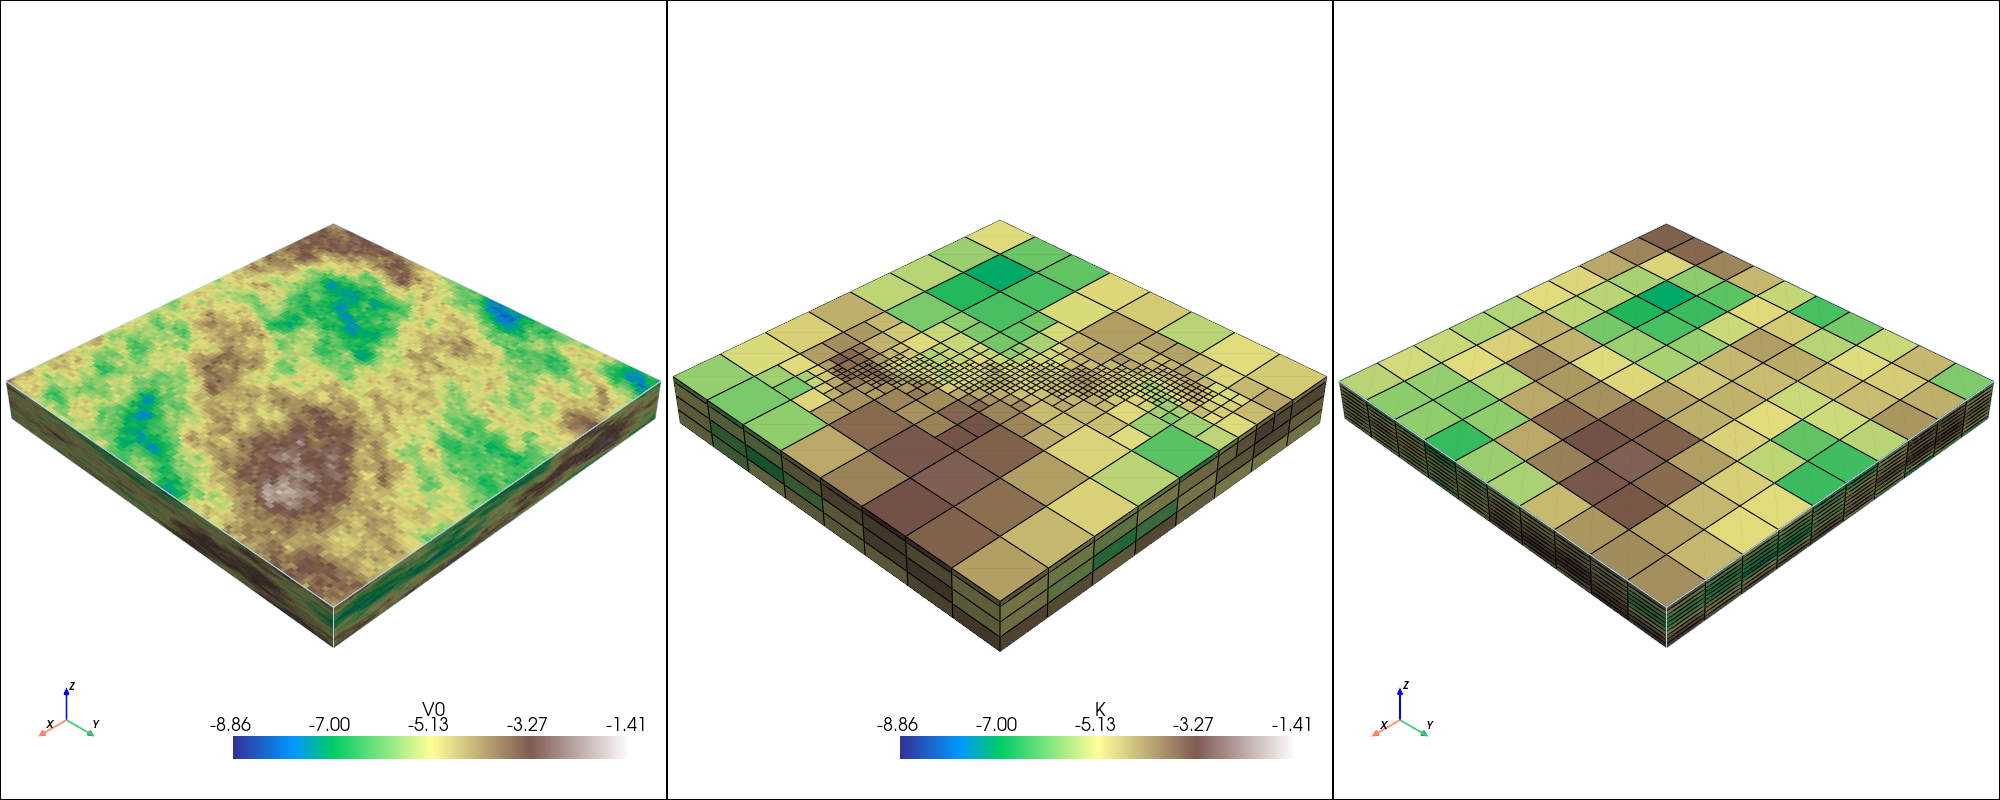

In [49]:
import pyvista as pv
pv.set_plot_theme("document")
pv.set_jupyter_backend('static')

pl = pv.Plotter(shape=(1, 3), window_size=[2000, 800])
pl.subplot(0, 0)
geone.imgplot3d.drawImage3D_surface(field_img, plotter=pl, cmap="terrain", opacity=1)

pl.subplot(0, 1)
pl.add_mesh(gwf_mesh, opacity=1, scalars="K", cmap="terrain", clim=[field_img.val.min(), field_img.val.max()], show_edges=True)

pl.subplot(0, 2)
arr = field_kxx
arr = np.flipud(np.flip(arr, axis=1))   
img = geone.img.Img(nx=arr.shape[2], ny=arr.shape[1], nz=arr.shape[0], sx=sx_grid*10, sy=sy_grid*10, sz=sz_grid*10, ox=0, oy=0, oz=-100, nv=1, val=arr.flatten())  
geone.imgplot3d.drawImage3D_surface(img, plotter=pl, cmap="terrain", opacity=1, show_edges=True, cmin=field_img.val.min(), cmax=field_img.val.max())   

pl.show()

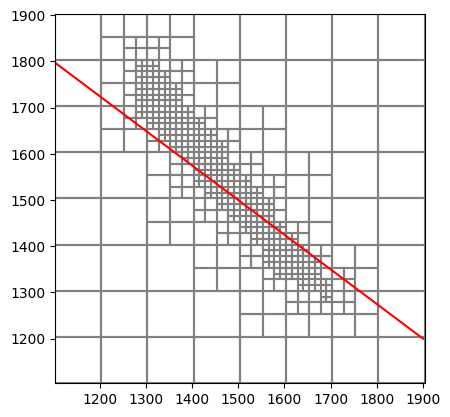

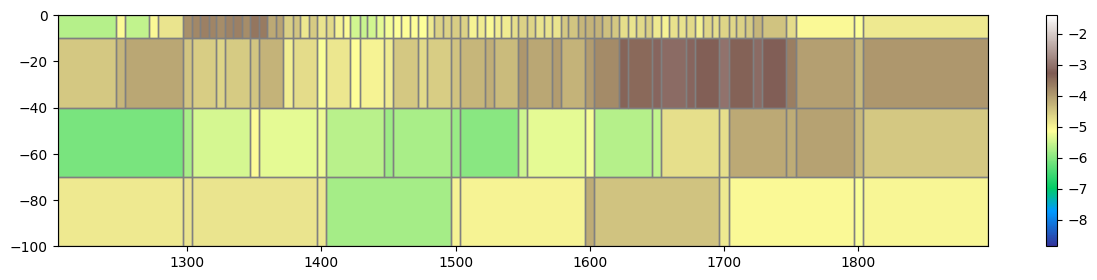

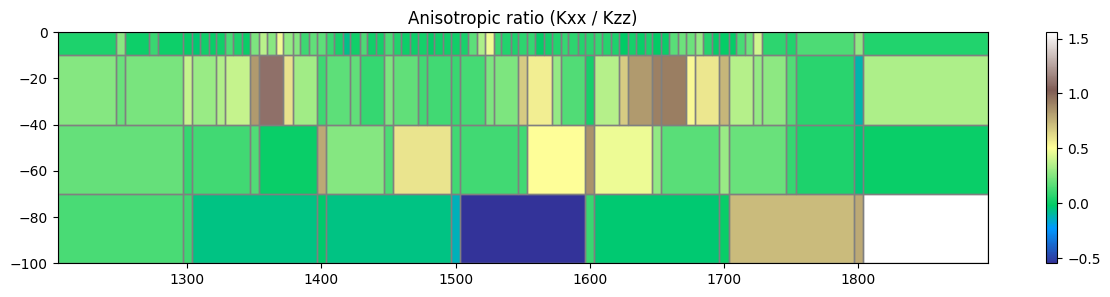

In [50]:
# plot a cross section
from flopy.plot import PlotCrossSection

linex, liney = [1100, 1900], [1800, 1200]

mm = flopy.plot.PlotMapView(model=ms)
mm.plot_grid()
plt.plot(linex, liney, "r-")
plt.show()

fig = plt.figure(figsize=(15, 3))
xsect = PlotCrossSection(model=ms,geographic_coords=True, line={"line": [linex, liney]})

g = xsect.plot_array(Kxx, alpha=1, cmap="terrain", vmin=field_img.val.min(), vmax=field_img.val.max())
plt.colorbar(g)
xsect.plot_grid()
plt.show()

fig = plt.figure(figsize=(15, 3))
xsect = PlotCrossSection(model=ms,geographic_coords=True, line={"line": [linex, liney]})

g = xsect.plot_array(Kxx - Kzz, alpha=1, cmap="terrain")
plt.title("Anisotropic ratio (Kxx / Kzz)")
plt.colorbar(g)
xsect.plot_grid()
plt.show()
